# MOTIF ANALYSIS PIPELINE 

In [1]:
import pandas as pd
import os
import Slim as slim
import glob
import re
import importlib
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import random
importlib.reload(slim)

<module 'Slim' from '/home/gogllab/Desktop/Quantitative_Interactomics/SlimSearch/Slim.py'>

### 1. File Collection and Processing

In [2]:
# Retrieve and sort all motif3 files for Human in the specified folder
Human_df = sorted(glob.glob("/home/gogllab/Desktop/SlimSearch/HUMAN/motif_3/SLIM_H_motif3_*.txt"))
Mouse_df = sorted(glob.glob("/home/gogllab/Desktop/SlimSearch/MOUSE/motif_3/SLIM_M_motif3_*.txt"))

# Concatenate these files into a single .txt file
slim.concat_motif_files(Human_df, "/home/gogllab/Desktop/SlimSearch/HUMAN/SLIM_H_motif3.txt")
slim.concat_motif_files(Mouse_df, "/home/gogllab/Desktop/SlimSearch/MOUSE/SLIM_M_motif3.txt")

/home/gogllab/Desktop/Quantitative_Interactomics/SlimSearch/Slim.py:25: DtypeWarning: Columns (41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(fp, sep="\t") for fp in file_paths]


Fichier combiné sauvegardé sous : /home/gogllab/Desktop/SlimSearch/HUMAN/SLIM_H_motif3.txt
Fichier combiné sauvegardé sous : /home/gogllab/Desktop/SlimSearch/MOUSE/SLIM_M_motif3.txt


### 2. Frequency Calculation Proteome


In [3]:

# Calculate frequency of each motif in the proteome 
human_df = sorted([
    f for f in glob.glob("/home/gogllab/Desktop/SlimSearch/HUMAN/SLIM_H_motif*.txt")
    if re.fullmatch(r"SLIM_H_motif\d+\.txt", os.path.basename(f))
])
mouse_df = sorted([
    f for f in glob.glob("/home/gogllab/Desktop/SlimSearch/MOUSE/SLIM_M_motif*.txt")
    if re.fullmatch(r"SLIM_M_motif\d+\.txt", os.path.basename(f))
])

table_human = slim.proteome_motif_frequencies(human_df, species="Human", output_file="OUTPUT/H_proteome_freq.txt")
table_mouse = slim.proteome_motif_frequencies(mouse_df, species="Mouse", output_file="OUTPUT/M_proteome_freq.txt")

Results saved to: OUTPUT/H_proteome_freq.txt
Results saved to: OUTPUT/M_proteome_freq.txt


### 3. Partner Protein Analysis  

In [4]:
df = pd.read_csv("/home/gogllab/Desktop/Projet_SRC_HCK/Python_First_Part/output//Matching.csv", header=[0, 1])

#human
all_partners_info, partners_by_bait, intersection_partners = slim.generate_partners_motifs_table(
    df=df,  
    motif_folder="./HUMAN",
    species="Human",
    baits=["SRC", "HCK"],
    output_path="OUTPUT"
)

freq_results = slim.analyze_motif_enrichment(
    df=df, 
    motif_folder="./HUMAN",
    species="Human",
    baits=["SRC", "HCK"],
    output_path="OUTPUT"
)


#Mouse
all_partners_info, partners_by_bait, intersection_partners = slim.generate_partners_motifs_table(
    df=df,  
    motif_folder="./MOUSE",
    species="Mouse",
    baits=["SRC", "HCK"],
    output_path="OUTPUT"
)
freq_results = slim.analyze_motif_enrichment(
    df=df, 
    motif_folder="./MOUSE",
    species="Mouse",
    baits=["SRC", "HCK"],
    output_path="OUTPUT"
)

Comprehensive partners and motifs data saved to: OUTPUT/Human_comprehensive_partners_motifs.tsv
Results saved to: OUTPUT/H_partners_freq.txt
Comprehensive partners and motifs data saved to: OUTPUT/Mouse_comprehensive_partners_motifs.tsv
Results saved to: OUTPUT/M_partners_freq.txt


### 4. Statistical Analysis (p-val, FDR correction, log2(FC))

In [5]:
# Read previously generated tables
freq_human = pd.read_csv("OUTPUT/H_proteome_freq.txt", sep="\t")
freq_mouse = pd.read_csv("OUTPUT/M_proteome_freq.txt", sep="\t")
partners_human = pd.read_csv("OUTPUT/H_partners_freq.txt", sep="\t")
partners_mouse = pd.read_csv("OUTPUT/M_partners_freq.txt", sep="\t")

# Calculate p-values
result_human_with_pval = slim.compute_motif_enrichment_pvalues(freq_human, partners_human, species="Human")
result_mouse_with_pval = slim.compute_motif_enrichment_pvalues(freq_mouse, partners_mouse, species="Mouse")

# Apply FDR correction
human_pval_FDR = slim.apply_fdr_correction(result_human_with_pval)
mouse_pval_FDR = slim.apply_fdr_correction(result_mouse_with_pval)

# Save results with FDR
human_pval_FDR.to_csv("OUTPUT/H_pval_FDR.txt", sep="\t", index=False)
mouse_pval_FDR.to_csv("OUTPUT/M_pval_FDR.txt", sep="\t", index=False)


In [6]:
# Load FDR files
df_pval_human = pd.read_csv("OUTPUT/H_pval_FDR.txt", sep="\t")
df_pval_mouse = pd.read_csv("OUTPUT/M_pval_FDR.txt", sep="\t")

# Add FoldChange and log2FC columns
df_FC_human = slim.calculate_fold_change(df_pval_human)
df_FC_mouse = slim.calculate_fold_change(df_pval_mouse)

# Save results
df_FC_human.to_csv("OUTPUT/H_FC.txt", sep="\t", index=False)
df_FC_mouse.to_csv("OUTPUT/M_FC.txt", sep="\t", index=False)

In [7]:
# Extract top motifs
top_human = slim.extract_top_significant_motifs(
    input_file="OUTPUT/H_pval_FDR.txt",
    output_file="OUTPUT/H_top_motifs.txt"
)

top_mouse = slim.extract_top_significant_motifs(
    input_file="OUTPUT/M_pval_FDR.txt",
    output_file="OUTPUT/M_top_motifs.txt"
)

Significant motifs saved to : OUTPUT/H_top_motifs.txt
Significant motifs saved to : OUTPUT/M_top_motifs.txt


### 5. Visualization (VolcanoPlots)

Volcano plot saved: OUTPUT/volcano_plots/volcano_Human_SRC.png


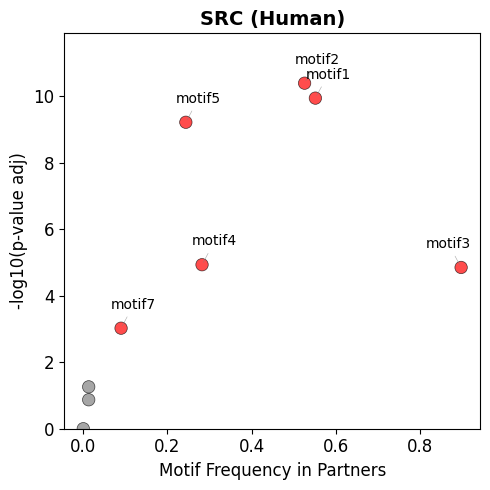

Volcano plot saved: OUTPUT/volcano_plots/volcano_Human_HCK.png


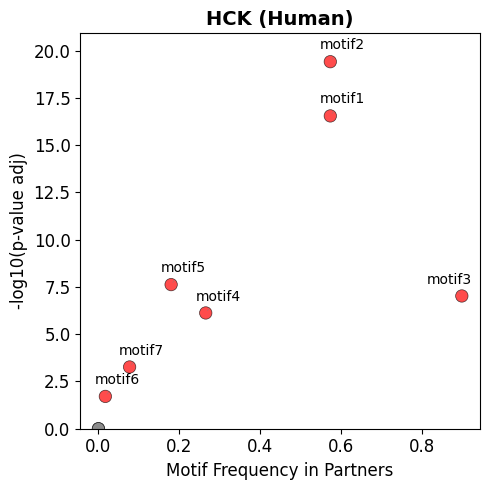

Volcano plot saved: OUTPUT/volcano_plots/volcano_Human_UNION.png


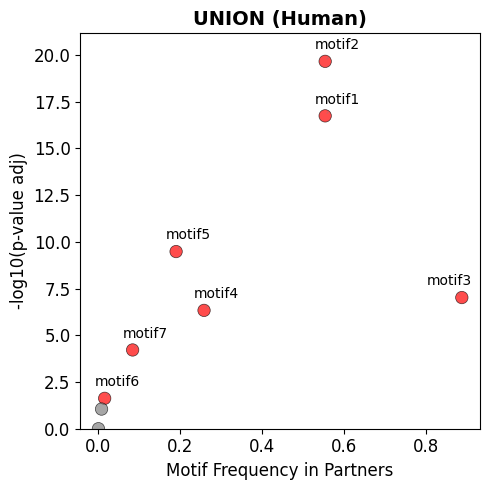

Volcano plot saved: OUTPUT/volcano_plots/volcano_Human_INTERSECTION.png


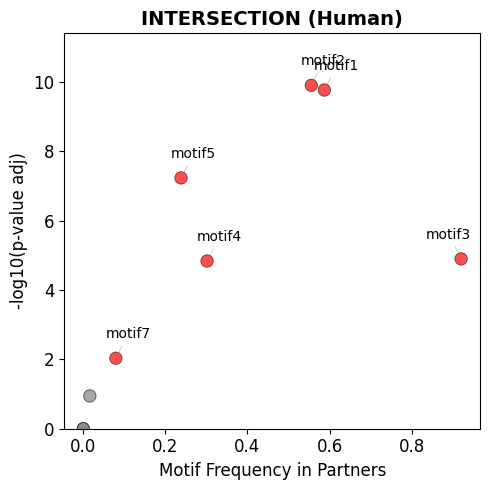

Volcano plot saved: OUTPUT/volcano_plots/volcano_Mouse_SRC.png


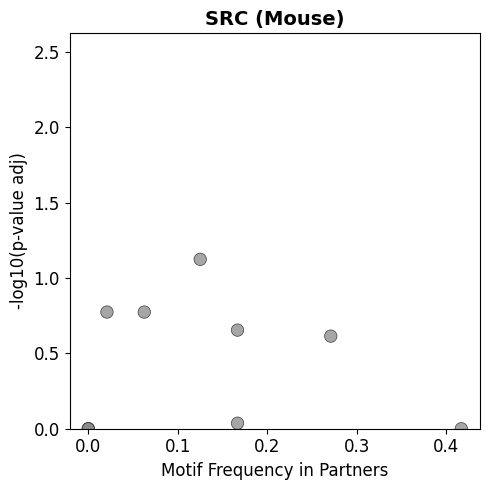

Volcano plot saved: OUTPUT/volcano_plots/volcano_Mouse_HCK.png


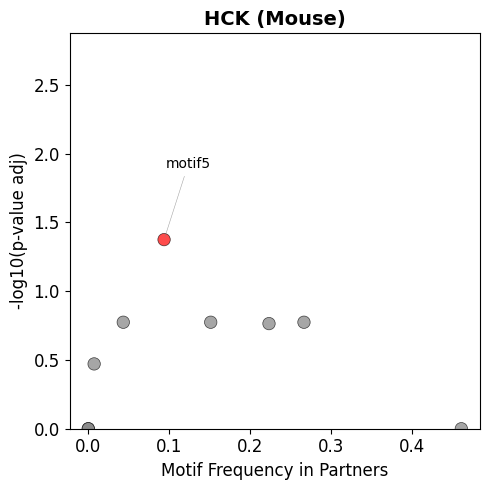

Volcano plot saved: OUTPUT/volcano_plots/volcano_Mouse_UNION.png


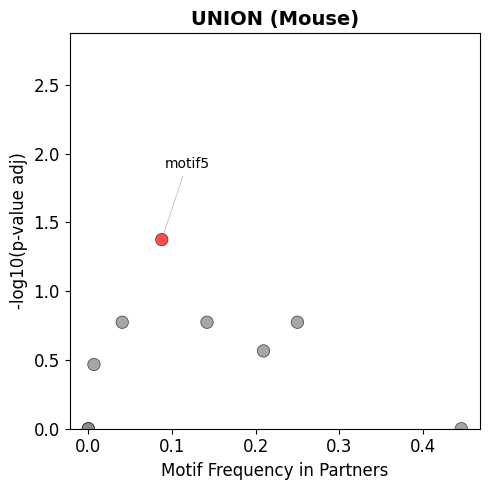

Volcano plot saved: OUTPUT/volcano_plots/volcano_Mouse_INTERSECTION.png


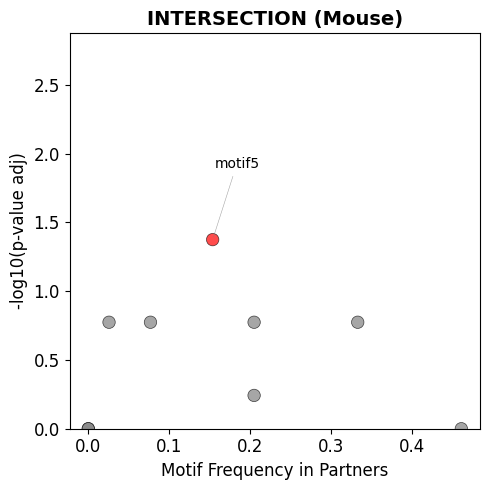

In [8]:
# Load data enriched with FoldChange + log2FC
df_human = pd.read_csv("OUTPUT/H_FC.txt", sep="\t")
df_mouse = pd.read_csv("OUTPUT/M_FC.txt", sep="\t")

# Generate volcano plots
slim.create_volcano_plots(df_human, "Human", output_dir="OUTPUT/volcano_plots")
slim.create_volcano_plots(df_mouse, "Mouse", output_dir="OUTPUT/volcano_plots")


In [ ]:
# Concatenate all motif files into a single file
Human_df = sorted(glob.glob("/home/gogllab/Desktop/SlimSearch/HUMAN/SLIM_H_motif*.txt"))
Mouse_df = sorted(glob.glob("/home/gogllab/Desktop/SlimSearch/MOUSE/SLIM_M_motif*.txt"))

slim.concat_motif_files(Human_df, "/home/gogllab/Desktop/SlimSearch/HUMAN/SLIM_H_all_motif.txt")
slim.concat_motif_files(Mouse_df, "/home/gogllab/Desktop/SlimSearch/MOUSE/SLIM_M_all_motif.txt")

### REPRENDRE ICI !!!!!!!!!!!!!!

In [ ]:

df= slim.fetch_uniprot_sequences(
    input_file="OUTPUT/Human_comprehensive_partners_motifs.tsv",
    output_file="OUTPUT/H_partners_sequences.txt",
    batch_size=100
)

